In [1]:
# python kernel check
import sys
assert sys.version_info >= (3, 5)

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchsummary as summary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.autograd.profiler.profile(enabled=False)
torch.autograd.profiler.emit_nvtx(enabled=False)
torch.autograd.set_detect_anomaly(mode=False)

Files already downloaded and verified
Files already downloaded and verified


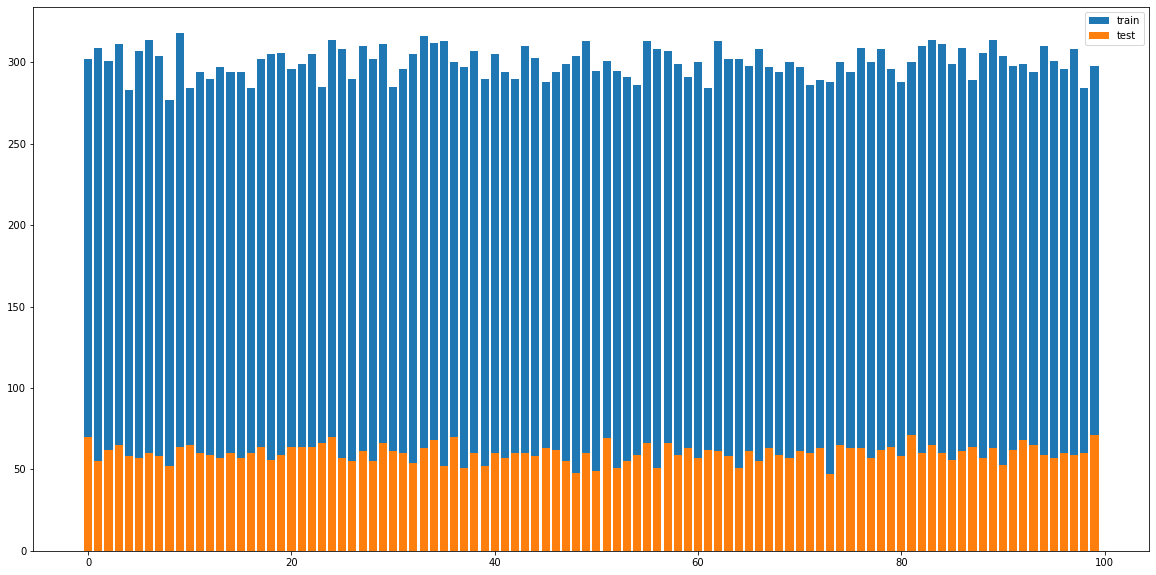

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [3]:
# load the CIFAR 100 dataset
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

BATCH = 32

original_trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=T.ToTensor())
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=T.ToTensor())

percentage = 0.6
train_size = int(percentage * len(original_trainset))
test_size = int(percentage * len(testset))
trainset, _ = torch.utils.data.random_split(original_trainset, [train_size, len(original_trainset) - train_size])
testset, _ = torch.utils.data.random_split(testset, [test_size, len(testset) - test_size])

trainloader = DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=2)


# check distribution of classes
trainset_distribution = np.zeros(100)
for i in range(len(trainset)):
    trainset_distribution[trainset[i][1]] += 1

testset_distribution = np.zeros(100)
for i in range(len(testset)):
    testset_distribution[testset[i][1]] += 1

plt.figure(figsize=(20, 10))
plt.bar(np.arange(100), trainset_distribution, label='train')
plt.bar(np.arange(100), testset_distribution, label='test')
plt.legend()
plt.show()

# get the class names from the dataset
classes = original_trainset.classes
print(classes)


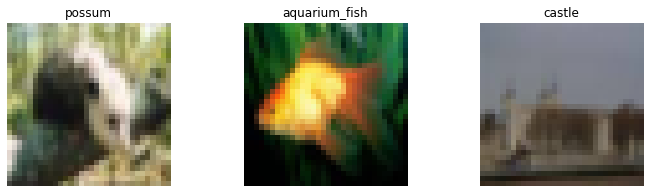

In [4]:
#  display 3 images from the dataset at random

plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(1, 3, i+1)
    img, label = trainset[np.random.randint(len(trainset))]
    plt.imshow(img.permute(1, 2, 0))
    plt.title(classes[label])
    plt.axis('off')
plt.show()

In [5]:
#  define the network architecture

class Net(nn.Module):
    def __init__(self, ch1:int, ch2:int, ch3:int, ch4:int) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(3, ch1, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(ch1, ch2, 3)
        self.conv3 = nn.Conv2d(ch2, ch3, 3)
        self.conv4 = nn.Conv2d(ch3, ch4, 3)
        self.lin_shape = ch4*9*9
        self.fc1 = nn.Linear(self.lin_shape, 100)
        # self.fc2 = nn.Linear(100, 100)
        # self.fc3 = nn.Linear(100, 100)
        self.act = nn.SELU()

        self.name = f"Net({ch1}_{ch2}_{ch3}_{ch4})"
        self.debug = False

    def forward(self, x):
        if self.debug: print(x.shape)
        x = self.act(self.conv1(x))
        if self.debug: print(x.shape)
        x = self.pool(x)
        if self.debug: print(x.shape)
        x = self.act(self.conv2(x))
        # if self.debug: print(x.shape)
        # x = self.pool(x)
        if self.debug: print(x.shape)
        x = self.act(self.conv3(x))
        if self.debug: print(x.shape)
        # x = self.pool(x)
        # if self.debug: print(x.shape)
        x = self.act(self.conv4(x))
        if self.debug: print(x.shape)
        x = x.view(-1, self.lin_shape)
        if self.debug: print(x.shape)
        x = self.fc1(x)
        if self.debug: print(x.shape)

        return x

#  define device to use for training
mydev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Net(6,9,12,3).to(mydev)

net.debug = True
summary.summary(net, (3, 32, 32))
net.debug = False


torch.Size([2, 3, 32, 32])
torch.Size([2, 6, 30, 30])
torch.Size([2, 6, 15, 15])
torch.Size([2, 9, 13, 13])
torch.Size([2, 12, 11, 11])
torch.Size([2, 3, 9, 9])
torch.Size([2, 243])
torch.Size([2, 100])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 30, 30]             168
              SELU-2            [-1, 6, 30, 30]               0
         MaxPool2d-3            [-1, 6, 15, 15]               0
            Conv2d-4            [-1, 9, 13, 13]             495
              SELU-5            [-1, 9, 13, 13]               0
            Conv2d-6           [-1, 12, 11, 11]             984
              SELU-7           [-1, 12, 11, 11]               0
            Conv2d-8              [-1, 3, 9, 9]             327
              SELU-9              [-1, 3, 9, 9]               0
           Linear-10                  [-1, 100]          24,400
Total params: 26,374
Trainab

In [6]:
#  define the loss function and optimizer and scheduler

total_epochs = 30

criterion = nn.CrossEntropyLoss().to(mydev)
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9) # SGD generalises better than Adam, but is slower
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.005, steps_per_epoch=len(trainloader), epochs=total_epochs)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epochs, eta_min=0.00001)


In [7]:
# training and testing functions

def step(dataloader, model, loss_fn, optimizer=None, scheduler=None, train=True,verbose=0):
    size = len(dataloader.dataset)
    running_loss = 0.0
    correct = 0
    model.train(train)
    with torch.set_grad_enabled(train):
        with tqdm(total=len(dataloader), disable=verbose<2) as progress_bar:
            for batch, (X, y) in enumerate(dataloader):
                X, y = X.to(mydev), y.to(mydev)

                # Compute prediction and loss
                pred = model(X)
                loss = loss_fn(pred, y)

                if train:
                    # Backpropagation
                    optimizer.zero_grad(set_to_none=True)
                    loss.backward()
                    optimizer.step()
                    scheduler.step()

                running_loss += loss.item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                loss, current = loss.item(), batch * len(X)
                progress_bar.set_postfix_str(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                progress_bar.update(1)
            
            current = batch * len(X)
            progress_bar.set_postfix_str(f"{'Training' if train else 'Testing'} Accuracy: {(100*correct/size):>0.1f}%,\
                Avg loss: {running_loss/len(dataloader):>8f} loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            progress_bar.update(1)
            # if train and scheduler is not None:
                # scheduler.step(running_loss/len(dataloader))

    return (running_loss/len(dataloader), 100*correct/size)



In [8]:
# train loop


def train_loop(dataloader:dict, net, criterion, optimizer, scheduler, total_epochs=1, save=False, verbose=0):
    best_test_loss = np.inf

    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'lr': []}

    #  train the network
    #  if verbose < 1: don't show progress bar
    for t in tqdm(range(total_epochs), disable=verbose<1):
        
        #  train step
        res = step(dataloader["train"], net, criterion, optimizer, scheduler, train=True, verbose=verbose)
        history['train_loss'].append(res[0])
        history['train_acc'].append(res[1])
        # history['lr'].append(scheduler.get_last_lr()[0])
        # history['lr'].append(optimizer.param_groups[0]['lr'])
        history['lr'].append(scheduler.get_last_lr()[0])
        #  test step
        res = step(dataloader["test"], net, criterion, train=False, verbose=verbose)
        history['test_loss'].append(res[0])
        history['test_acc'].append(res[1])
        if save and res[0] < best_test_loss:
            best_test_loss = res[0]
            torch.save(net.state_dict(), f'model.pt')
    
    return history
    
    

In [11]:
#  explore the space of hyperparameters

df = pd.DataFrame(columns=["ch1", "ch2", "ch3", "ch4", "train_loss", "train_acc", "test_loss", "test_acc", "lr"])

dataloader = {"train": trainloader, "test": testloader}

for ch1 in [3, 6, 9, 12]:
    for ch2 in [3, 6, 9, 12]:
        for ch3 in [3, 6, 9, 12]:
            for ch4 in [3, 6, 9, 12]:
                net = Net(ch1, ch2, ch3, ch4).to(mydev)
                explore_epochs = 5
                # reset the optimizer and scheduler
                optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)
                scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=explore_epochs, eta_min=0.00001)
                history = train_loop(dataloader, net, criterion, optimizer, scheduler, total_epochs=explore_epochs, verbose=2)
                df = df.append({"ch1": ch1, "ch2": ch2, "ch3": ch3, "ch4": ch4, "train_loss": history['train_loss'], "train_acc": history['train_acc'], "test_loss": history['test_loss'], "test_acc": history['test_acc'], "lr": history['lr']}, ignore_index=True)
                df.to_csv("df.csv", index=False)
                print(f"ch1: {ch1}, ch2: {ch2}, ch3: {ch3}, ch4: {ch4}, train_loss: {history['train_loss'][-1]}, train_acc: {history['train_acc'][-1]}, test_loss: {history['test_loss'][-1]}, test_acc: {history['test_acc'][-1]}, lr: {history['lr'][-1]}")

df.to_csv("df.csv", index=False)
df

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: 

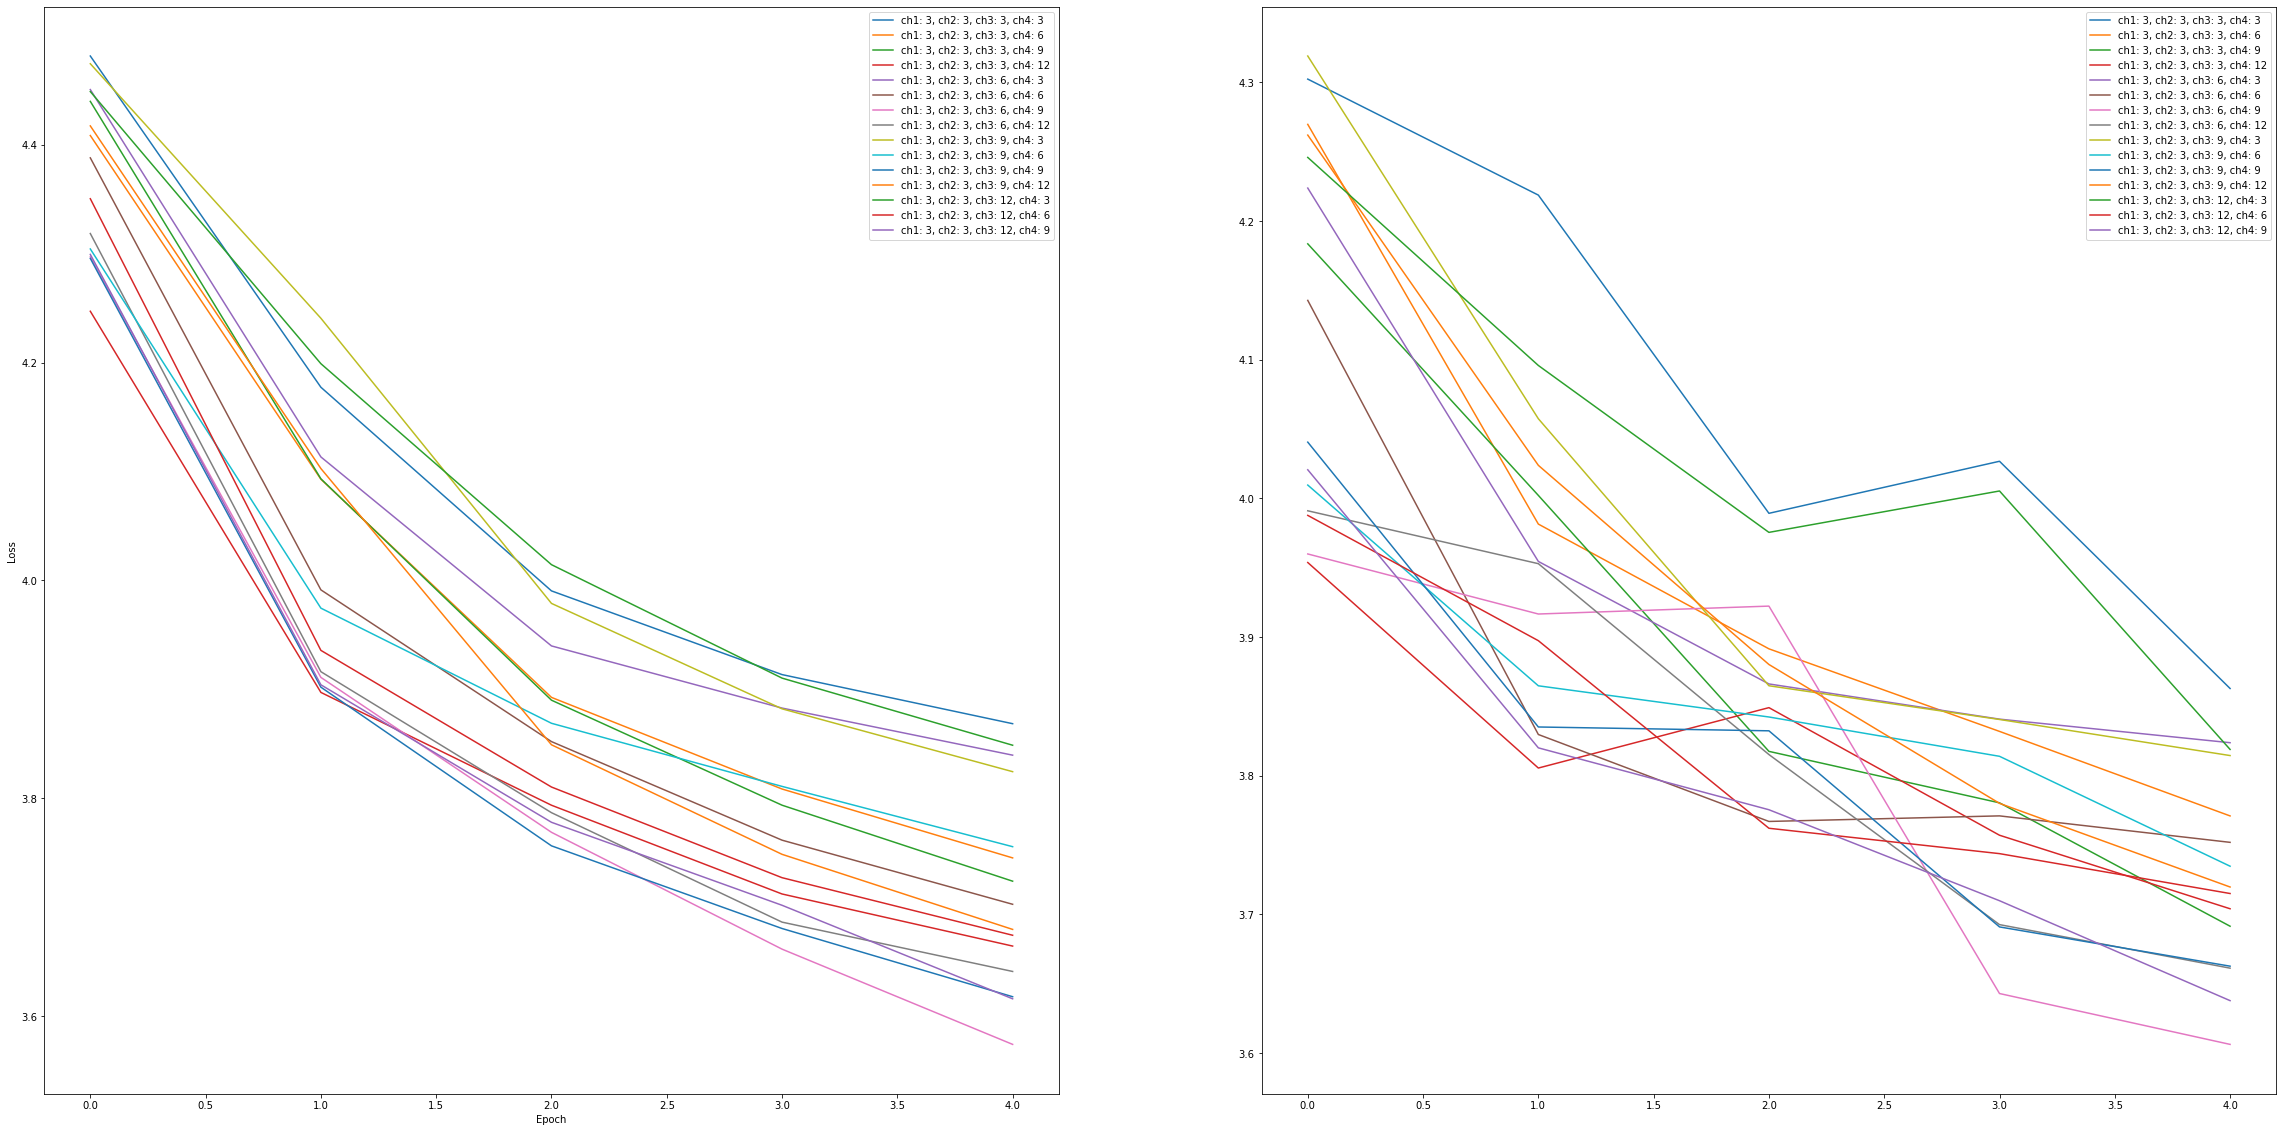

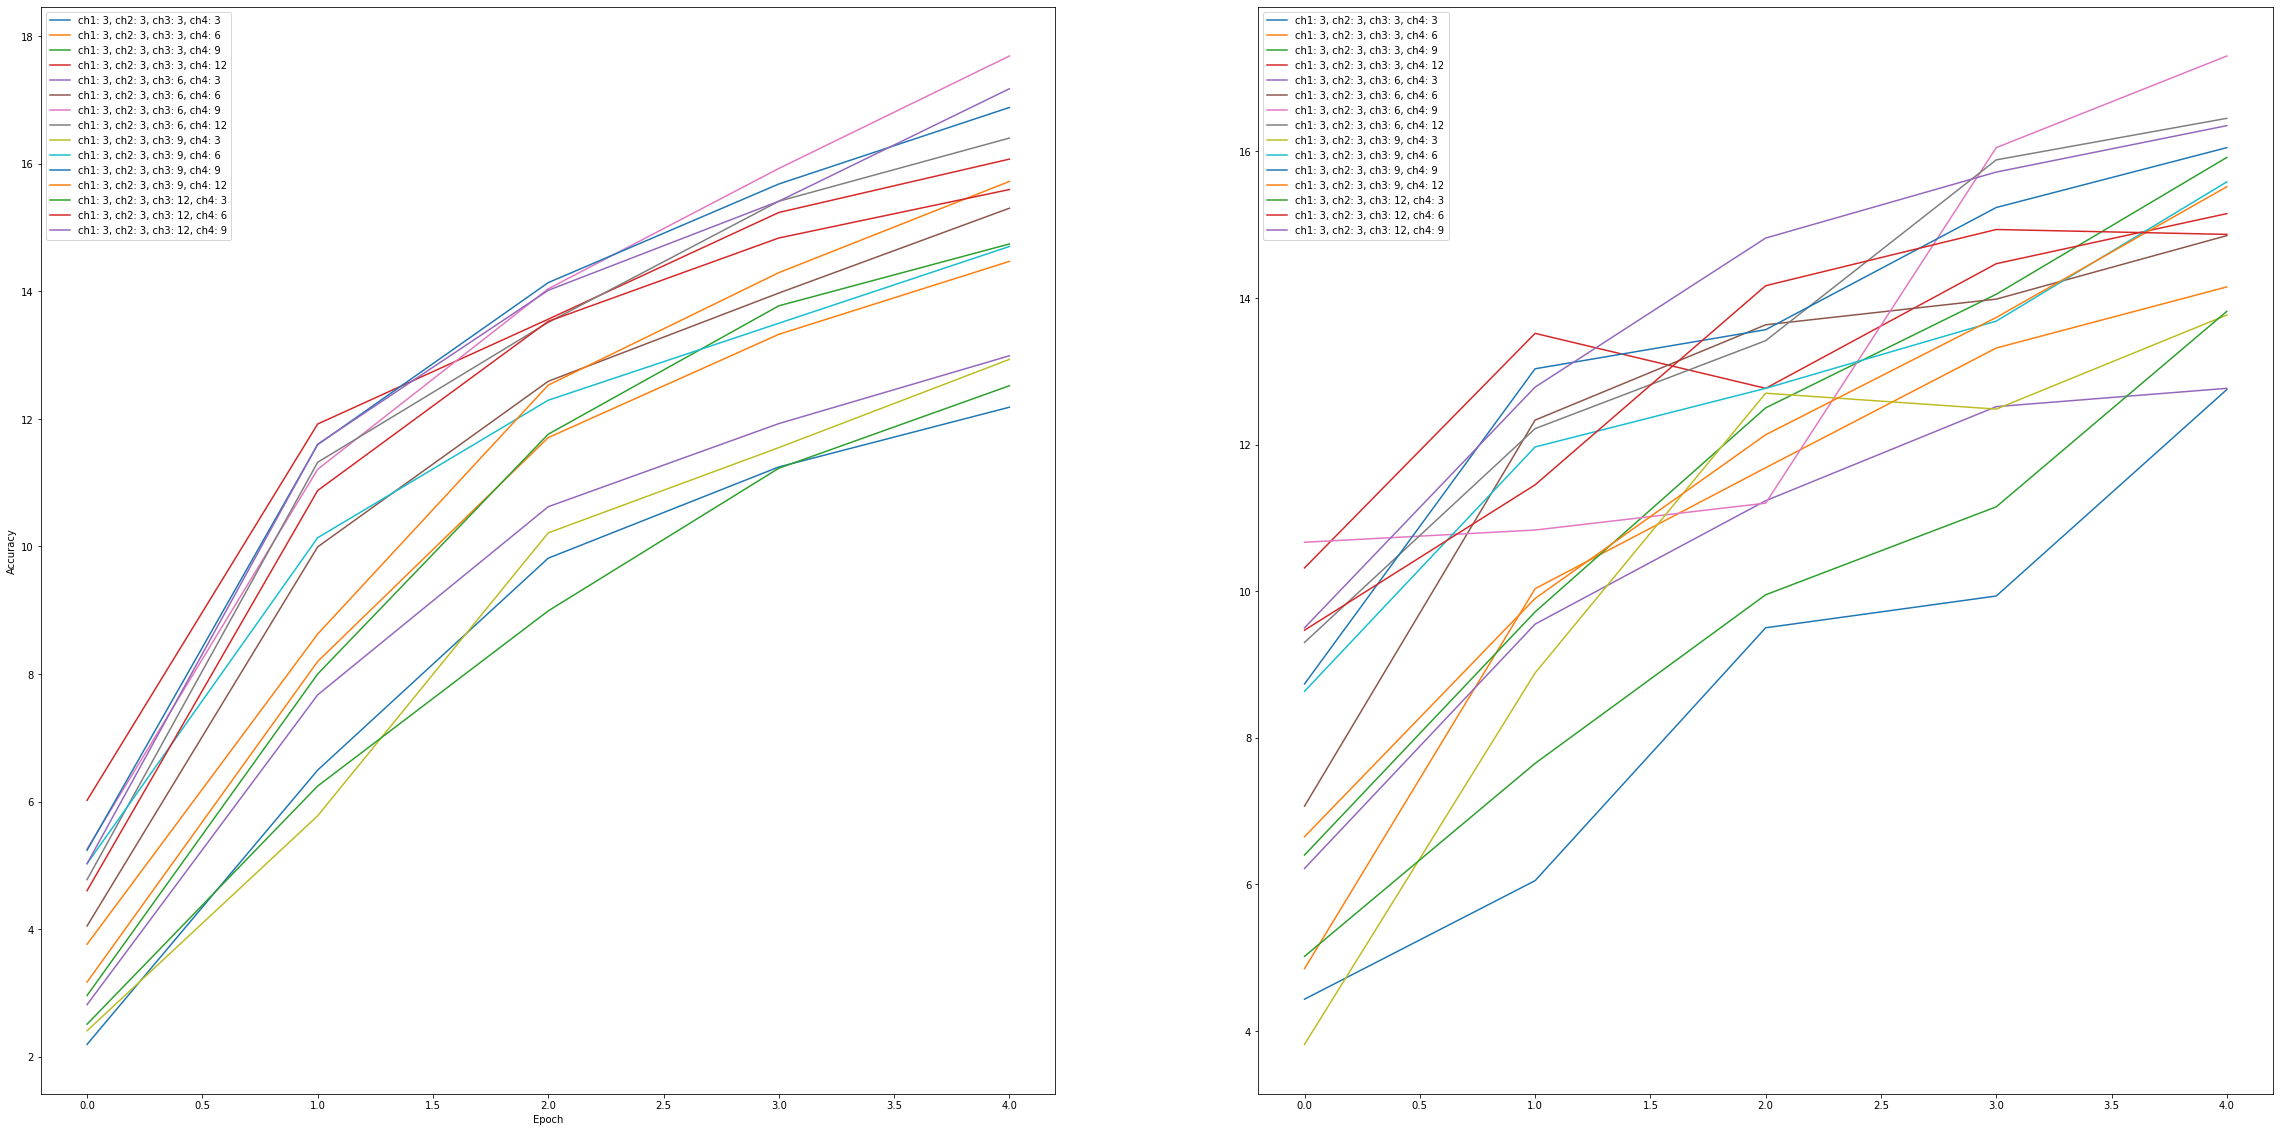

In [ ]:
#  graph the results

def parse(l):
    l = l.split("[")[1].split("]")[0].split(", ")
    l = [float(i) for i in l]
    return l


df = pd.read_csv("df.csv")

fig, ax = plt.subplots(1, 2, figsize=(40, 20))
# for each line in the dataframe
for i in range(len(df)):
    # plot the train loss
    ax[0].plot(parse(df["train_loss"][i]), label=f"ch1: {df['ch1'][i]}, ch2: {df['ch2'][i]}, ch3: {df['ch3'][i]}, ch4: {df['ch4'][i]}")
    # plot the test loss
    ax[1].plot(parse(df["test_loss"][i]), label=f"ch1: {df['ch1'][i]}, ch2: {df['ch2'][i]}, ch3: {df['ch3'][i]}, ch4: {df['ch4'][i]}")
# set the legend
ax[0].legend()
ax[1].legend()
# set the labels
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(40, 20))
# for each line in the dataframe
for i in range(len(df)):
    # plot the train accuracy
    ax[0].plot(parse(df["train_acc"][i]), label=f"ch1: {df['ch1'][i]}, ch2: {df['ch2'][i]}, ch3: {df['ch3'][i]}, ch4: {df['ch4'][i]}")
    # plot the test accuracy
    ax[1].plot(parse(df["test_acc"][i]), label=f"ch1: {df['ch1'][i]}, ch2: {df['ch2'][i]}, ch3: {df['ch3'][i]}, ch4: {df['ch4'][i]}")
# set the legend
ax[0].legend()
ax[1].legend()
# set the labels
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
plt.show()


In [ ]:
#  train the network with the best hyperparameters

# find the best hyperparameters
#  for each line in the dataframe
best = {}
best_test_loss = np.inf
for i in range(len(df)):
    # if the test loss is the best
    val = parse(df["test_loss"][i])[-1]
    if val < best_test_loss:
        # save the best test loss
        best_test_loss = parse(df["test_loss"][i])[-1]
        # save the best hyperparameters
        best = {"ch1": df["ch1"][i], "ch2": df["ch2"][i], "ch3": df["ch3"][i], "ch4": df["ch4"][i]}

if best == {}: raise Exception("No best hyperparameters found")

print(best)

# train the network with the best hyperparameters
net = Net(best["ch1"], best["ch2"], best["ch3"], best["ch4"]).to(mydev)
explore_epochs = 100
# reset the optimizer and scheduler
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=explore_epochs, eta_min=0.00001)
history = train_loop(dataloader, net, criterion, optimizer, scheduler, total_epochs=explore_epochs, save=True)

# plot the results
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(history["train_loss"], label="train_loss")
ax[0].plot(history["test_loss"], label="test_loss")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[0].legend()
ax[1].plot(history["train_acc"], label="train_acc")
ax[1].plot(history["test_acc"], label="test_acc")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend()
plt.show()

#  compute confusion matrix
confusion_matrix = np.zeros((100, 100), dtype=int)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(mydev), labels.to(mydev)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(len(labels)):
            confusion_matrix[labels[i]][predicted[i]] += 1

#  plot confusion matrix
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(confusion_matrix, cmap="Blues")
ax.set_xlabel("predicted")
ax.set_ylabel("true")
plt.show()



{'ch1': 3, 'ch2': 3, 'ch3': 6, 'ch4': 9}


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

KeyboardInterrupt: 

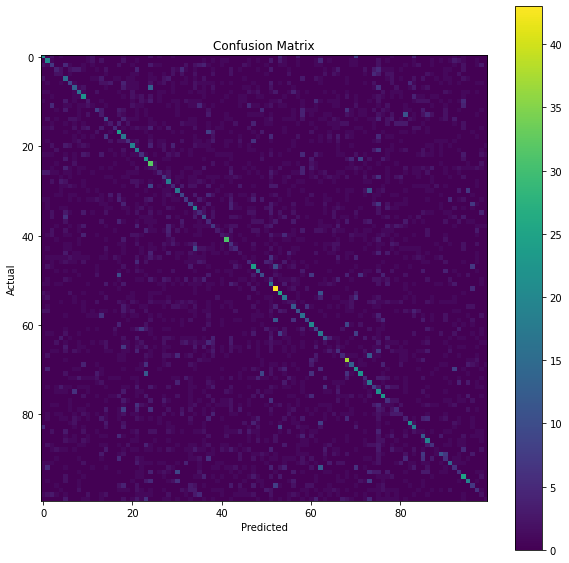

Top 10 classes with the most errors:
index class  (error count) 
1. oak_tree (43)
2. road (37)
3. cockroach (32)
4. lawn_mower (31)
5. orange (26)
6. wardrobe (25)
7. castle (24)
8. maple_tree (24)
9. cloud (23)
10. skyscraper (23)


In [ ]:
# find the last model
net.load_state_dict(torch.load("model.pt"))
net.eval()

# compute the confusion matrix

confusion_matrix = np.zeros((100, 100), dtype=np.int32)

with torch.no_grad():
    for X, y in testloader:
        X, y = X.to(mydev), y.to(mydev)
        pred = net(X)
        pred = pred.argmax(1)
        for i in range(len(y)):
            confusion_matrix[y[i], pred[i]] += 1

# plot the confusion matrix

plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#  print the top 10 classes with the most errors

print('Top 10 classes with the most errors:')
print("index class  (error count) ")

for i in range(10):
    max_error = np.max(confusion_matrix)
    max_error_index = np.argmax(confusion_matrix)
    row = max_error_index // 100
    col = max_error_index % 100
    print(f'{i+1}. {classes[row]} ({max_error})')
    confusion_matrix[row, :] = 0
    confusion_matrix[:, col] = 0